Import libraries

In [1]:
import pandas.core.series
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

Import dataset

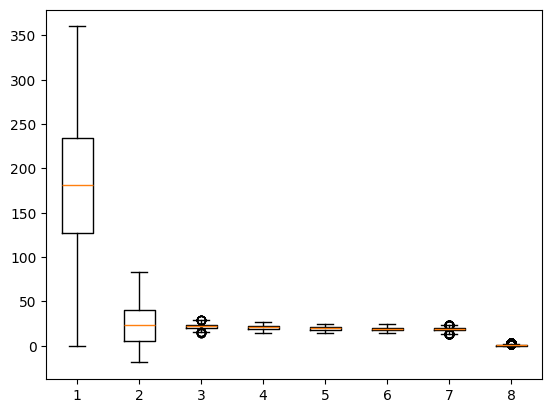

              alpha         delta             u             g             r  \
count  97814.000000  97814.000000  97814.000000  97814.000000  97814.000000   
mean     177.599567     24.150785     22.071659     20.630475     19.636028   
std       96.535545     19.654619      2.239830      2.023809      1.834898   
min        0.005528    -18.785328     14.311050     14.520380     14.168760   
25%      127.478240      5.144758     20.332845     18.938333     18.100860   
50%      180.868223     23.685853     22.157445     21.092910     20.105900   
75%      233.890810     39.908920     23.670853     22.131880     21.031697   
max      359.999810     83.000519     29.234380     26.714980     25.121300   

                  i             z      redshift  
count  97814.000000  97814.000000  97814.000000  
mean      19.065337     18.747675      0.521963  
std        1.728697      1.737013      0.595197  
min       13.899870     13.559570     -0.009971  
25%       17.699045     17.430633     

In [208]:
df = pd.read_csv('preprocessed_data.csv',index_col=0)
X = df.drop(columns=['class'])
Y = df['class']
plt.boxplot(X)
plt.show()
print(df.describe())

Discretization

In [209]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

dc.fit(X[['alpha']])
X['alpha']= dc.transform(X[['alpha']])

dc.fit(X[['delta']])
X['delta']= dc.transform(X[['delta']])

dc.fit(X[['u']])
X['u']= dc.transform(X[['u']])

dc.fit(X[['g']])
X['g']= dc.transform(X[['g']])

dc.fit(X[['r']])
X['r']= dc.transform(X[['r']])

dc.fit(X[['i']])
X['i']= dc.transform(X[['i']])

dc.fit(X[['z']])
X['z']= dc.transform(X[['z']])

dc.fit(X[['redshift']])
X['redshift']= dc.transform(X[['redshift']])

print(X.shape)

(97814, 8)


Dataset 2

In [215]:
X = pd.read_csv('../Dataset/TestGroup_2b.csv')
print(X.shape)
Y = pd.read_csv('preprocessed_data.csv',index_col=0)
Y = Y.drop(columns=['alpha','delta','u','g','r','i','z','redshift'])
print(Y.shape)

(97814, 8)
(97814, 1)


Set Up Evaluation Parameters

In [60]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
score = {
    'gini' : [],
    'entropy' : [],
}
for criteria in criterion:  
    for depth in max_depth:
        clf = tree.DecisionTreeClassifier(criterion=criteria, max_depth=depth)
        score[criteria].append(np.mean(cross_val_score(clf, X, Y, cv=10)))
    
print(score)

KeyboardInterrupt: 

Plotting results (Gini)

Text(0.5, 1.0, 'Score vs. Max Depth (Gini Index)')

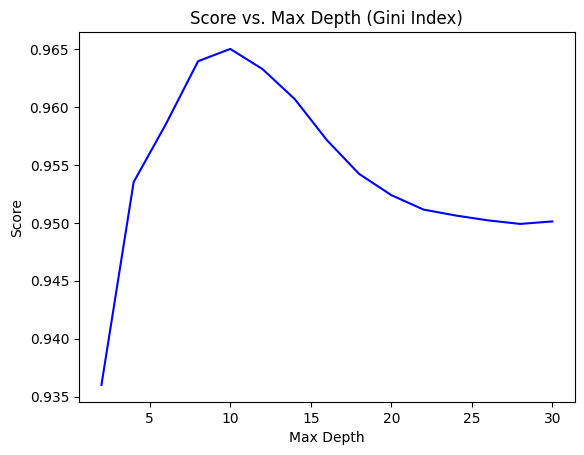

In [31]:
gini = score['gini']
entropy = score['entropy']


plt.plot(max_depth, gini, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Gini Index)')

Entropy

Text(0.5, 1.0, 'Score vs. Max Depth (Entropy)')

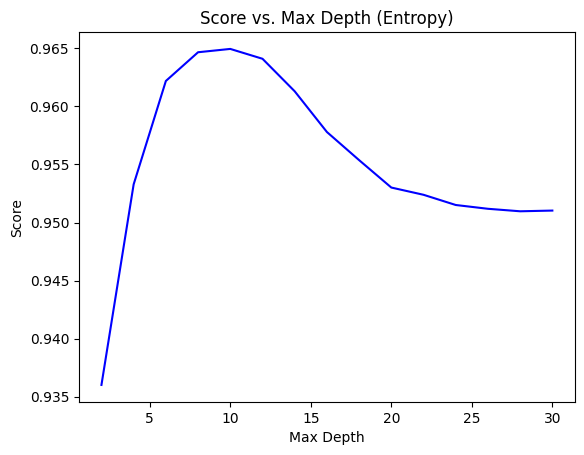

In [32]:
plt.plot(max_depth, entropy, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Entropy)')

Log Loss

Text(0.5, 1.0, 'Score vs. Max Depth (Log Loss)')

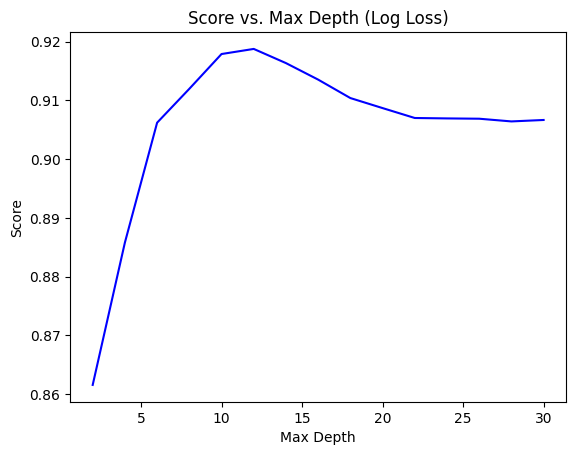

In [7]:
plt.plot(max_depth, log_loss, linestyle='-', color='b')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Score vs. Max Depth (Log Loss)')

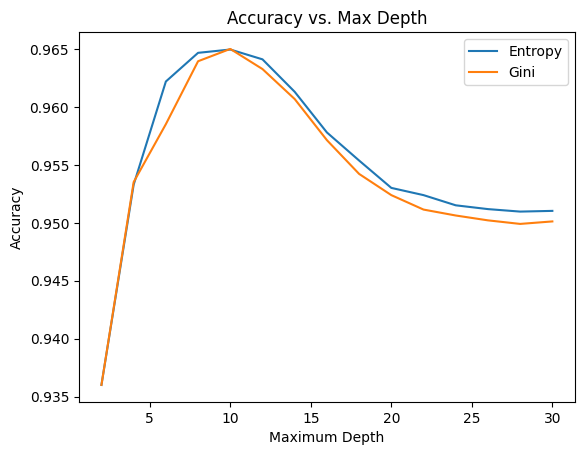

In [33]:
max_depth = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
plt.plot(max_depth, entropy)
plt.plot(max_depth, gini)
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend(['Entropy','Gini'])
plt.title('Accuracy vs. Max Depth')
plt.show()

Final Processing

In [218]:
print("Best Max Depth (Gini): ", (np.argmax(gini)+1)*2)
print("Score: ", max(gini))
print("Best Max Depth (Entropy): ", (np.argmax(entropy)+1)*2)
print("Score: ", max(entropy))


Best Max Depth (Gini):  10
Score:  0.9650049935333967
Best Max Depth (Entropy):  10
Score:  0.9649538834225414


In [219]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=10)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
clf.fit(x_train, y_train)
print(x_test.shape)


(19563, 8)


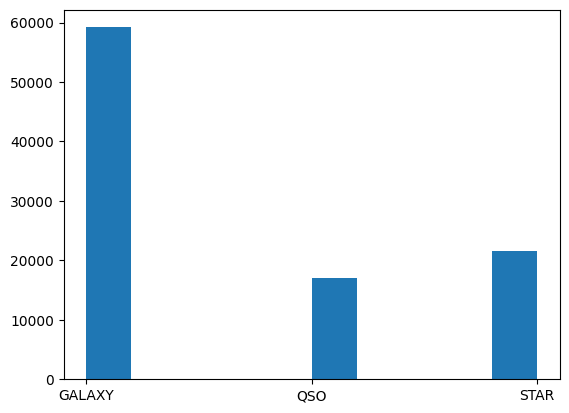

In [174]:
clf.score(x_test, y_test)
plt.hist(df['class'])
plt.show()

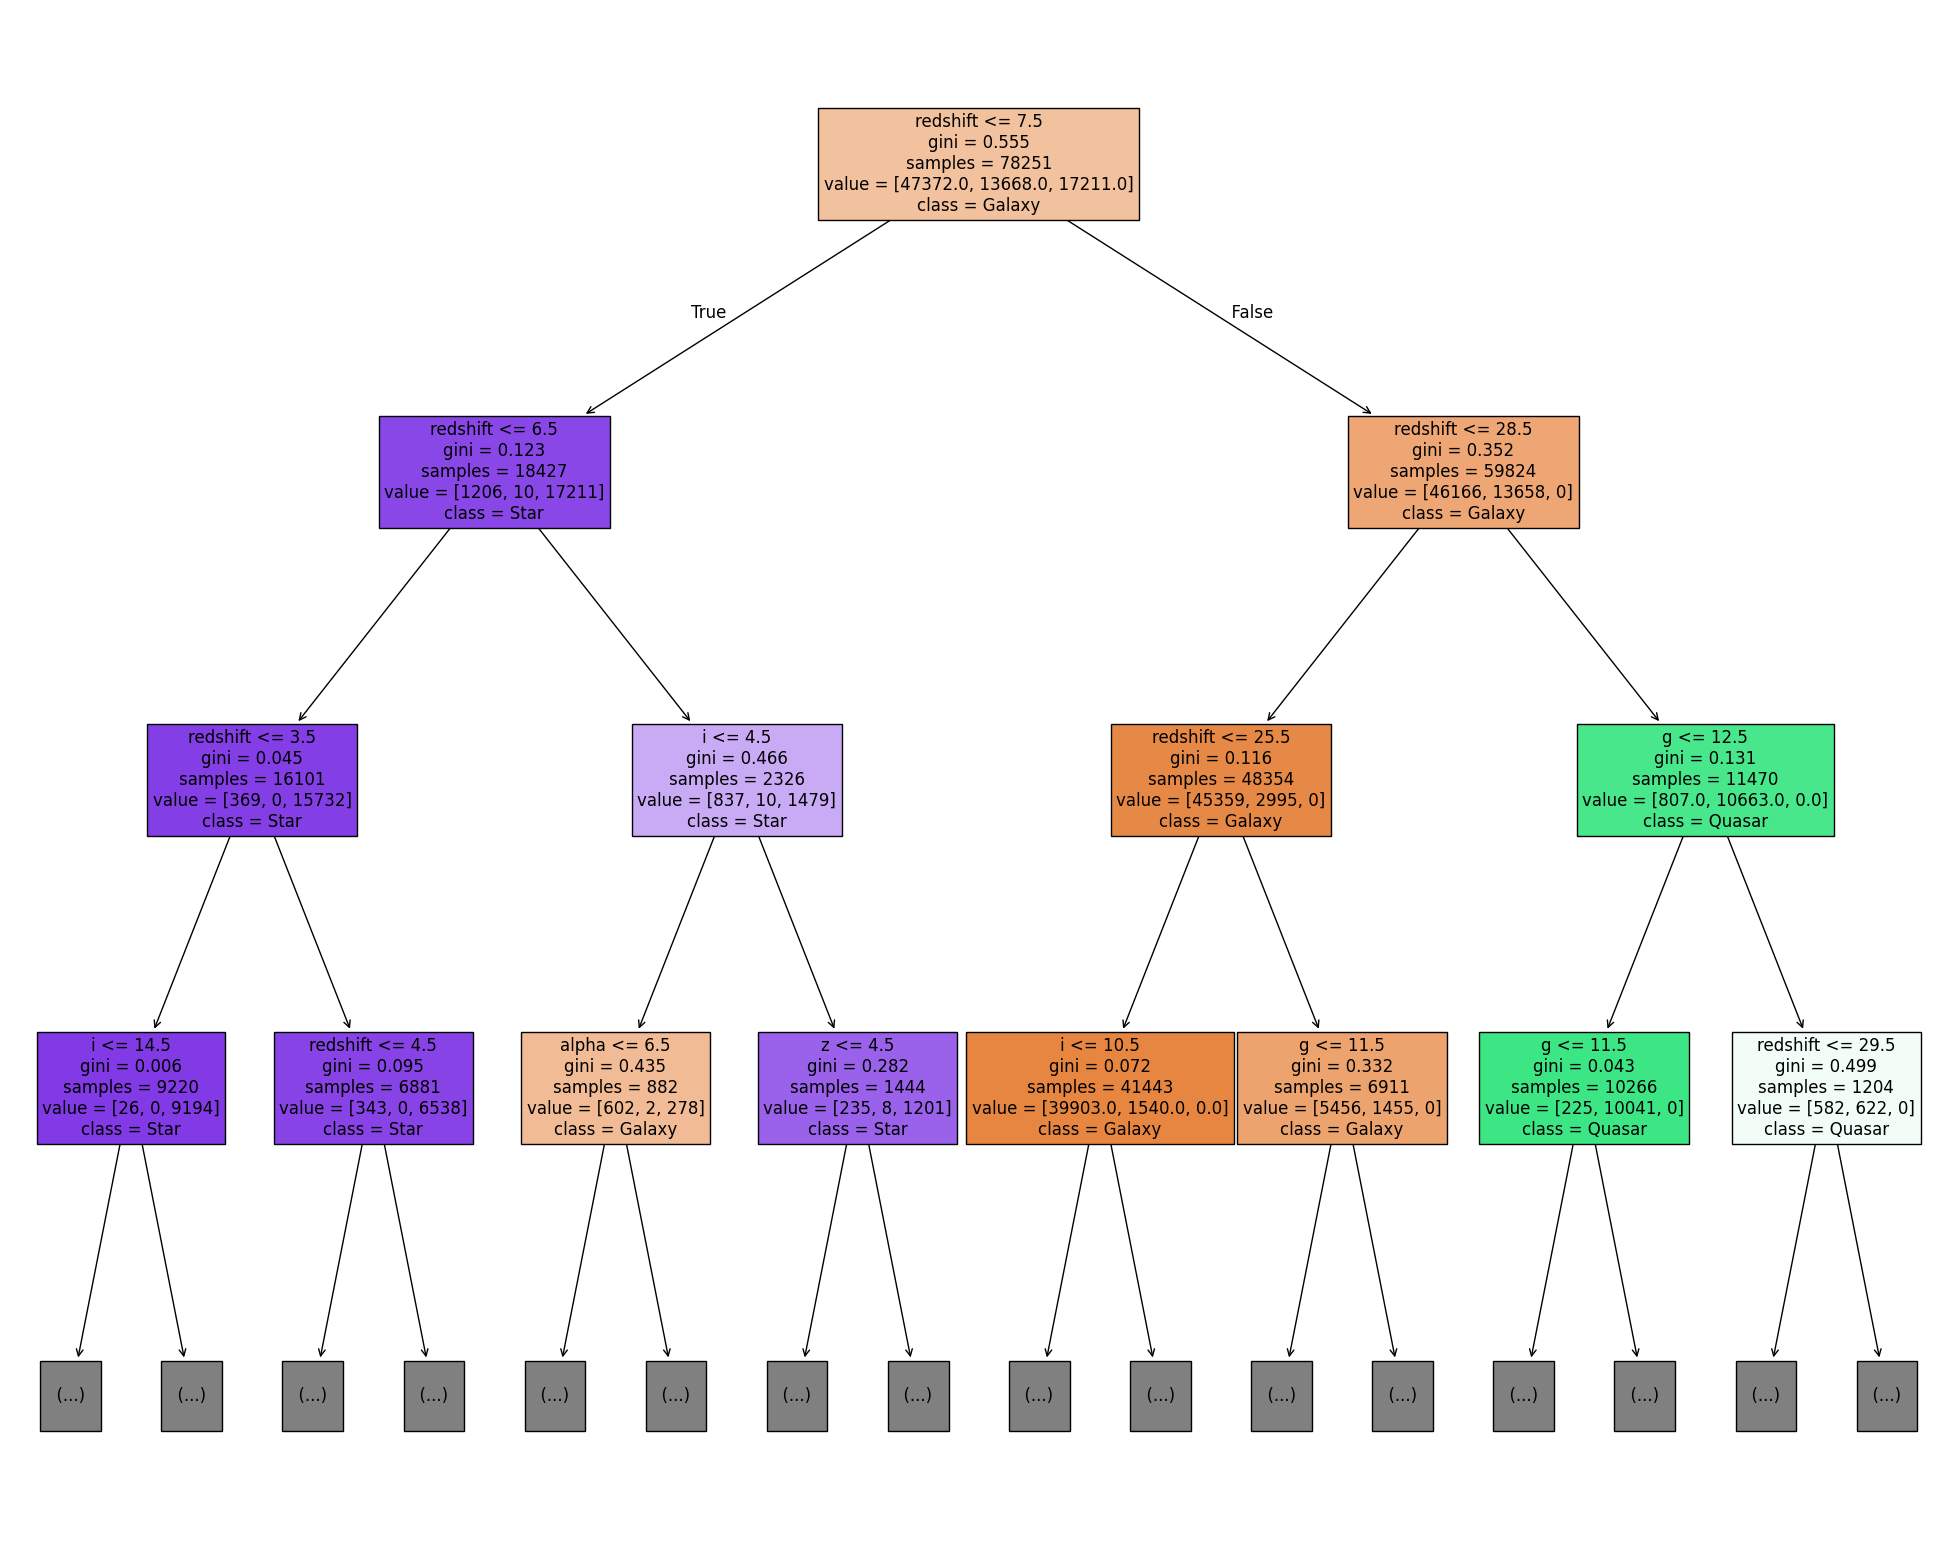

In [220]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                    feature_names=['alpha', 'delta', 'u','g','r','i','z','redshift'],
                    class_names=['Galaxy', 'Quasar', 'Star'],
                    max_depth=3,
                    fontsize=12,
                    filled=True)    

AUC

In [221]:

if type(y_test) == pd.core.frame.DataFrame:
    y_test = y_test.iloc[:,0]

print(metrics.roc_auc_score(y_test, clf.predict_proba(x_test), multi_class='ovr'))

0.9865782680805265


In [222]:
print(metrics.classification_report(y_test, clf.predict(x_test), target_names=['Galaxy','Quasar','Star']))

              precision    recall  f1-score   support

      Galaxy       0.97      0.98      0.97     11832
      Quasar       0.95      0.91      0.93      3437
        Star       0.97      0.98      0.98      4294

    accuracy                           0.96     19563
   macro avg       0.96      0.95      0.96     19563
weighted avg       0.96      0.96      0.96     19563



In [21]:

metrics.RocCurveDisplay.from_estimator(clf, x_test, y_test, multi_class='ovr')
plt.show()

ValueError: Expected 'estimator' to be a binary classifier. Got 3 classes instead.